# Integration of ZarrDataset with PyTorch's DataLoader

In [1]:
import zarrdataset as zds

import torch
from torch.utils.data import DataLoader

C:\Users\cervaf\Documents\Apps\miniconda3\envs\zds-dev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# These are images from the Image Data Resource (IDR) 
# https://idr.openmicroscopy.org/ that are publicly available and were 
# converted to the OME-NGFF (Zarr) format by the OME group. More examples
# can be found at Public OME-Zarr data (Nov. 2020)
# https://www.openmicroscopy.org/2020/11/04/zarr-data.html

filenames = [
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.4/idr0073A/9798462.zarr"
]

In [3]:
import random
import numpy as np

# For reproducibility
np.random.seed(478963)
torch.manual_seed(478964)
random.seed(478965)

## Extracting patches of size 1024x1024 pixels from a Whole Slide Image (WSI)

Sample the image randomly

In [4]:
patch_size = dict(Y=1024, X=1024)
patch_sampler = zds.BlueNoisePatchSampler(patch_size=patch_size)

Create a dataset from the list of filenames. All those files should be stored within their respective group "0".

Also, specify that the axes order in the image is Time-Channel-Depth-Height-Width (TCZYX), so the data can be handled correctly

In [5]:
image_specs = zds.ImagesDatasetSpecs(
  filenames=filenames,
  data_group="0",
  source_axes="TCZYX",
)

my_dataset = zds.ZarrDataset(image_specs,
                             patch_sampler=patch_sampler,
                             shuffle=True)

In [6]:
my_dataset

ZarrDataset (PyTorch support:True, tqdm support :True)
Modalities: images
Transforms order: []
Using images modality as reference.
Using <class 'zarrdataset._samplers.BlueNoisePatchSampler'> for sampling patches of size {'Z': 1, 'Y': 1024, 'X': 1024}.

Add a pre-processing step before creating the image batches, where the input arrays are casted from int16 to float32.

In [7]:
import torchvision

img_preprocessing = torchvision.transforms.Compose([
    zds.ToDtype(dtype=np.float32),
])

my_dataset.add_transform("images", img_preprocessing)

In [8]:
my_dataset

ZarrDataset (PyTorch support:True, tqdm support :True)
Modalities: images
Transforms order: [('images',)]
Using images modality as reference.
Using <class 'zarrdataset._samplers.BlueNoisePatchSampler'> for sampling patches of size {'Z': 1, 'Y': 1024, 'X': 1024}.

## Create a DataLoader from the dataset object

ZarrDataset is compatible with DataLoader from PyTorch since it is inherited from the IterableDataset class of the torch.utils.data module.

In [9]:
my_dataloader = DataLoader(my_dataset, num_workers=0)

In [10]:
samples = []
for i, sample in enumerate(my_dataloader):
    # Samples generated by DataLoaders have Batch (B) as first axes
    samples.append(np.moveaxis(sample[0, 0, :, 0].numpy(), 0, -1))

    print(f"Sample {i+1} with size {sample.shape}")

    if i >= 4:
        # Take only five samples for illustration purposes
        break

samples = np.hstack(samples)

C:\Users\cervaf\Documents\Apps\miniconda3\envs\zds-dev\lib\site-packages\boto3\compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


Sample 1 with size torch.Size([1, 1, 3, 1, 1024, 1024])


Sample 2 with size torch.Size([1, 1, 3, 1, 1024, 1024])


Sample 3 with size torch.Size([1, 1, 3, 1, 1024, 1024])


Sample 4 with size torch.Size([1, 1, 3, 1, 1024, 1024])


Sample 5 with size torch.Size([1, 1, 3, 1, 1024, 1024])


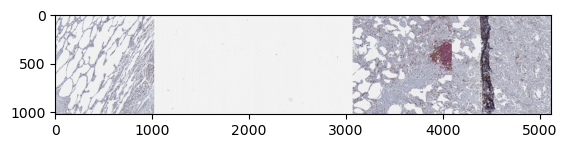

In [11]:
import matplotlib.pyplot as plt

plt.imshow(samples / 255.0)
plt.show()

## Multithread data loading with Torch's DataLoader

This example will use multiple workers to load patches of size 256x256 from the same image

In [12]:
patch_size = dict(Y=256, X=256)
patch_sampler = zds.BlueNoisePatchSampler(patch_size=patch_size)

Create a dataset from the list of filenames. All those files should be stored within their respective group "0".

Also, specify that the axes order in the image is Time-Channel-Depth-Height-Width (TCZYX), so the data can be handled correctly

In [13]:
image_specs = zds.ImagesDatasetSpecs(
  filenames=filenames,
  data_group="3",
  source_axes="TCZYX",
)

my_dataset = zds.ZarrDataset(image_specs,
                             patch_sampler=patch_sampler,
                             shuffle=True)

ZarrDataset performs some special operations for enabling multithread data loading without replicating the full dataset on each worker.

For this reason, ZarrDataset requires its own `worker_init_fn` initialization function: `zarrdataset_worker_init_fn`.

In [14]:
my_dataloader = DataLoader(my_dataset, num_workers=4,
                           worker_init_fn=zds.zarrdataset_worker_init_fn)

Now the data can be safely loaded using multiple workers.

In [15]:
samples = []
for i, sample in enumerate(my_dataloader):
    # Samples generated by DataLoaders have Batch (B) as first axes
    samples.append(np.moveaxis(sample[0, 0, :, 0].numpy(), 0, -1))

    print(f"Sample {i+1} with size {sample.shape}")

    if i >= 4:
        # Take only five samples for illustration purposes
        break

samples = np.hstack(samples)

RuntimeError: DataLoader worker (pid(s) 9504, 4452, 17544, 21832) exited unexpectedly

In [ ]:
plt.imshow(samples)
plt.show()